## Dataset Understanding

In [ ]:
import os
import shutil
import kagglehub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# Download dataset and split train into new_train/val (80/20)
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
source_path = os.path.join(dataset_path, "chest_xray")
target_path = os.getcwd()

# Copy train and test folders
for folder in ["train", "test"]:
    src = os.path.join(source_path, folder)
    dst = os.path.join(target_path, folder)
    if not os.path.exists(dst):
        shutil.copytree(src, dst)
        print(f"Copied {folder} to current directory.")
    else:
        print(f"{folder} already exists in current directory.")

# Create new_train and val directories
new_train_dir = os.path.join(target_path, "new_train")
val_dir = os.path.join(target_path, "val")
classes = ["NORMAL", "PNEUMONIA"]

# Remove existing val folder from keggle import as we will not use it (too small i.e 16 images only)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
    print("Removed existing val directory.")

for cls in classes:
    os.makedirs(os.path.join(new_train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

for cls in classes:
    images = [os.path.join(target_path, "train", cls, img) for img in os.listdir(os.path.join(target_path, "train", cls))]
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
    for img in train_imgs:
        shutil.copy(img, os.path.join(new_train_dir, cls, os.path.basename(img)))
    for img in val_imgs:
        shutil.copy(img, os.path.join(val_dir, cls, os.path.basename(img)))

print("Train set split completed: new_train and val directories created.")


train already exists in current directory.
test already exists in current directory.
Removed existing val directory.
Train set split completed: new_train and val directories created.


New_train set - NORMAL: 1206, PNEUMONIA: 3487
Val set - NORMAL: 269, PNEUMONIA: 775
Test set - NORMAL: 234, PNEUMONIA: 390


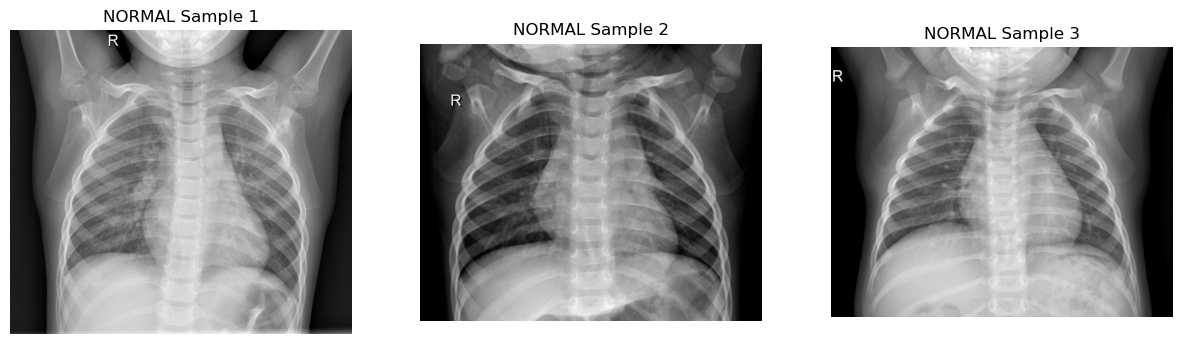

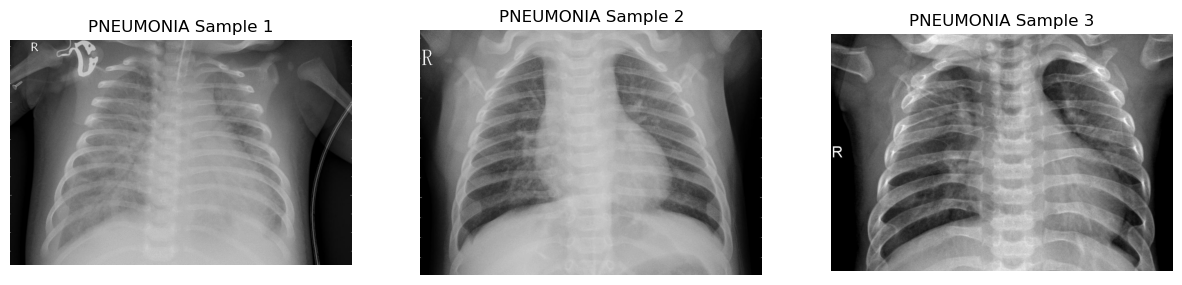

In [ ]:
# Count images to analyze class distribution
def count_images(directory):
    normal = len(os.listdir(os.path.join(directory, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(directory, "PNEUMONIA")))
    return normal, pneumonia

for folder in ["new_train", "val", "test"]:
    folder_path = os.path.join(target_path, folder)
    normal, pneumonia = count_images(folder_path)
    print(f"{folder.capitalize()} set - NORMAL: {normal}, PNEUMONIA: {pneumonia}")

# Visualize sample images
def visualize_samples(directory, class_name, num_samples=3):
    class_dir = os.path.join(directory, class_name) 
    img_names = os.listdir(class_dir)
    img_names = img_names[:num_samples]
    
    img_paths = []
    for img_name in img_names:
        img_path = os.path.join(class_dir, img_name)
        img_paths.append(img_path)
    plt.figure(figsize=(15, 5))
    
    for i, img_path in enumerate(img_paths):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name} Sample {i + 1}")
        plt.axis('off')   
    plt.show()

visualize_samples(new_train_dir, "NORMAL")
visualize_samples(new_train_dir, "PNEUMONIA")

## Data Preprocessing

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
new_train_dir = os.path.join(os.getcwd(), "new_train")
val_dir = os.path.join(os.getcwd(), "val")
test_dir = os.path.join(os.getcwd(), "test")

# Load and preprocess images
def load_and_preprocess_images(directory, target_size=(150, 150)):
    images = []
    labels = []     # 0 for NORMAL, 1 for PNEUMONIA
    classes = ["NORMAL", "PNEUMONIA"]

    for cls in classes:
        # e.g cls_path is new_train/NORMAL
        cls_path = os.path.join(directory, cls)
        for img_name in os.listdir(cls_path):

            # e.g img_path is new_train/NORMAL/image1.jpg
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as RGB
            img = cv2.resize(img, target_size)  # Resize to 150x150
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(0 if cls == "NORMAL" else 1)

    images = np.array(images)
    labels = np.array(labels)

    """
    Example: Initial structure of one image before reshaping
    image = [
        [[R1, G1, B1], [R2, G2, B2]],  # Row 0
        [[R3, G3, B3], [R4, G4, B4]]   # Row 1
    ]

    image = [
        [[1, 2, 3], [4, 5, 6]],
        [[7, 8, 9], [10, 11, 12]]
    ]

    Shape: (2, 2, 3) (2 rows, 2 columns, 3 color channels) and 4 pixels in total 

    Example: Reshaped structure for LSTM input
    image = [
        [1, 2, 3, 4, 5, 6],  # Row 0 flattened
        [7, 8, 9, 10, 11, 12] # Row 1 flattened
    ]

    Shape: (2, 6) (2 rows, 6 columns flattened)
    meaning: 
        > 2 time steps (rows)
        > 6 features per time step/row (2 pixels * 3 channels = 6)
    """

    # Reshape for LSTM: (samples, 150, 450)
    images = images.reshape(images.shape[0], images.shape[1], images.shape[1] * images.shape[3])
    return images, labels

X_train, y_train = load_and_preprocess_images(new_train_dir)
X_val, y_val = load_and_preprocess_images(val_dir)
X_test, y_test = load_and_preprocess_images(test_dir)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# Class weights for imbalance (Weight_i = count of other class / count of this class)
class_weights = {0: pneumonia/normal, 1: normal/pneumonia}  # NORMAL: ~2.89, PNEUMONIA: ~0.346

Train shape: (4693, 150, 450), Val shape: (1044, 150, 450), Test shape: (624, 150, 450)


## Building and training the LSTM Model (RNN) & MobileNet Model (CNN)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical i.e 0 becomes [1, 0], and 1 becomes [0, 1], because LSTM and MobileNet models use a 2-neuron output layer
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# LSTM Model (sequence = image (4693 in total), time-step = row (150 in total), features per time-step/row = 450 (150 pixels * 3 channels) )
lstm_model = Sequential([
    # LSTM (neurons (number of memory cells), input_shape (rows/time step, features per time-step/row), dropout (5% of 450 input connections/features dropped to prevent overfitting), recurrent_dropout (At each time step, drop 20% of the memory connections passed from the previous time step) , return_sequences (it outputs a sequence for the next LSTM layer))
    LSTM(250, input_shape=(150, 450), dropout=0.05, recurrent_dropout=0.20, return_sequences=True),
    LSTM(120, dropout=0.05, recurrent_dropout=0.20, return_sequences=True),
    LSTM(64, dropout=0.05, recurrent_dropout=0.20, return_sequences=False),
    Dense(250, activation='relu'),
    Dense(120, activation='relu'),
    Dense(64, activation='relu'),
    Dense(28, activation='relu'),
    Dense(2, activation='softmax')
])

# Updates the weights once per batch by appling gradient descent to minimize the loss function

# loss function is categorical_crossentropy because we have 2 classes (NORMAL and PNEUMONIA), it measures the difference between the true labels and predicted probabilities
# metrics is accuracy and just for reporting, it measures the percentage of correct predictions made
# adam optimizer uses the gradient of the loss function to update the weights
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Checkpoint to save best model after every epoch when pre-evaluation on validation set
lstm_checkpoint = ModelCheckpoint('lstm_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Train LSTM
lstm_history = lstm_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),     # pre-eval test
    epochs=10,                  # roughly 146 batches per epoch (4693/32)
    batch_size=32,
    class_weight=class_weights, # Weights are updated once per batch, not once per full epoch
    callbacks=[lstm_checkpoint]
)

# MobileNet Model
# include_top=False means we are not using the final pooling + dense layer of MobileNet, we will add our own layers
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
mobilenet_base.trainable = False  # Freeze base convolunational layer of MobileNet to prevent wight change and speed up training
mobilenet_model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Checkpoint
mobilenet_checkpoint = ModelCheckpoint('mobilenet_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Train MobileNet (use ImageDataGenerator for standard image input)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

# class_mode='categorical': Labels are one-hot encoded (2 classes)
# target_size=(150, 150): Resize images to 150x150
train_generator = train_datagen.flow_from_directory(new_train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[mobilenet_checkpoint]
)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5216 - loss: 0.5999

147/147 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5220 - loss: 0.5997 - val_accuracy: 0.6054 - val_loss: 0.6108
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6790 - loss: 0.5124

147/147 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6790 - loss: 0.5123 - val_accuracy: 0.7835 - val_loss: 0.5187
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7217 - loss: 0.4733 - val_accuracy: 0.6791 - val_loss: 0.6210
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7426 - loss: 0.4600

147/147 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.7423 - loss: 0.4601 - val_accuracy: 0.8008 - val_loss: 0.4182
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7605 - loss: 0.4310

147/147 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7605 - loss: 0.4310 - val_accuracy: 0.8094 - val_loss: 0.4680
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7892 - loss: 0.4111

147/147 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7892 - loss: 0.4111 - val_accuracy: 0.8381 - val_loss: 0.3873
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7834 - loss: 0.4246 - val_accuracy: 0.7241 - val_loss: 0.5493
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7961 - loss: 0.4004 - val_accuracy: 0.7653 - val_loss: 0.4797
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7850 - loss: 0.3994 - val_accuracy: 0.7835 - val_loss: 0.4623
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7683 - loss: 0.4147 - val_accuracy: 0.8266 - val_loss: 0.4116


C:\Users\hp\AppData\Local\Temp\ipykernel_8084\945951790.py:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step
Found 4693 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.


d:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8482 - loss: 0.3113

147/147 ━━━━━━━━━━━━━━━━━━━━ 106s 695ms/step - accuracy: 0.8486 - loss: 0.3106 - val_accuracy: 0.8908 - val_loss: 0.2723
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9191 - loss: 0.1728

147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 735ms/step - accuracy: 0.9192 - loss: 0.1727 - val_accuracy: 0.9358 - val_loss: 0.1592
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9507 - loss: 0.1174

147/147 ━━━━━━━━━━━━━━━━━━━━ 123s 839ms/step - accuracy: 0.9507 - loss: 0.1174 - val_accuracy: 0.9550 - val_loss: 0.1252
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9517 - loss: 0.1153

147/147 ━━━━━━━━━━━━━━━━━━━━ 132s 896ms/step - accuracy: 0.9517 - loss: 0.1152 - val_accuracy: 0.9569 - val_loss: 0.1340
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 922ms/step - accuracy: 0.9580 - loss: 0.0827 - val_accuracy: 0.9550 - val_loss: 0.1370
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9693 - loss: 0.0670

147/147 ━━━━━━━━━━━━━━━━━━━━ 129s 875ms/step - accuracy: 0.9693 - loss: 0.0670 - val_accuracy: 0.9684 - val_loss: 0.0873
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 124s 844ms/step - accuracy: 0.9722 - loss: 0.0730 - val_accuracy: 0.9636 - val_loss: 0.1012
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 807ms/step - accuracy: 0.9689 - loss: 0.0752 - val_accuracy: 0.9646 - val_loss: 0.0977
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 768ms/step - accuracy: 0.9716 - loss: 0.0685 - val_accuracy: 0.9674 - val_loss: 0.1092
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 784ms/step - accuracy: 0.9698 - loss: 0.0613 - val_accuracy: 0.9119 - val_loss: 0.2567


## Evaluation of Model

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.69      0.38      0.49       234
   PNEUMONIA       0.71      0.90      0.79       390

    accuracy                           0.70       624
   macro avg       0.70      0.64      0.64       624
weighted avg       0.70      0.70      0.68       624

Found 624 images belonging to 2 classes.


d:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 531ms/step
MobileNet Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.46      0.62       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.74       624
weighted avg       0.83      0.79      0.77       624



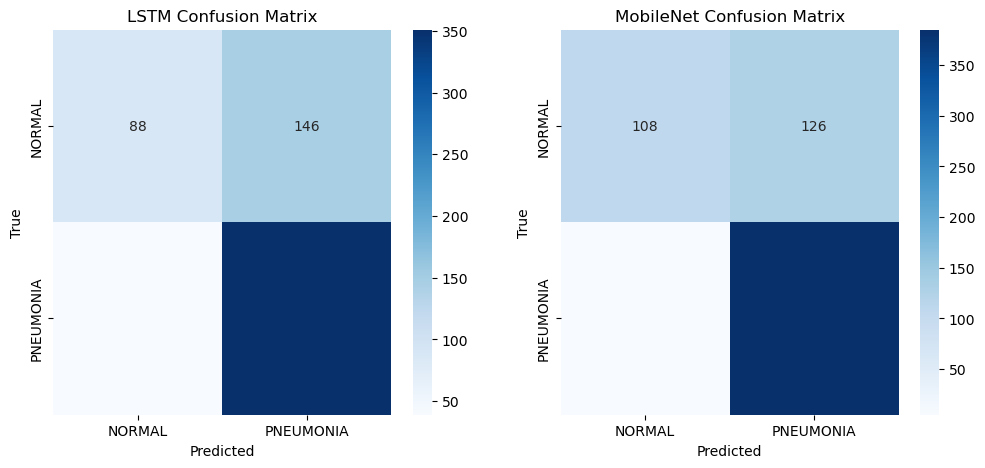

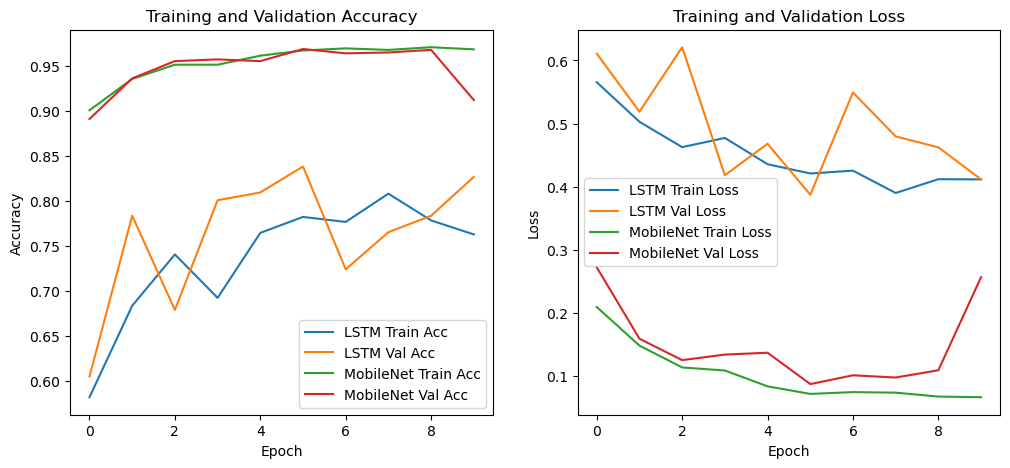

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load models
lstm_model = load_model('lstm_model.h5')
mobilenet_model = load_model('mobilenet_model.h5')

# Evaluate LSTM
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=1)
# Force confusion matrix to be 2x2 with fixed label order
lstm_cm = confusion_matrix(y_test, lstm_pred, labels=[0, 1])
lstm_report = classification_report(y_test, lstm_pred, target_names=['NORMAL', 'PNEUMONIA'])

print("LSTM Classification Report:")
print(lstm_report)

# Evaluate MobileNet
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)
mobilenet_pred = np.argmax(mobilenet_model.predict(test_generator), axis=1)
mobilenet_cm = confusion_matrix(test_generator.classes, mobilenet_pred, labels=[0, 1])
mobilenet_report = classification_report(test_generator.classes, mobilenet_pred, target_names=['NORMAL', 'PNEUMONIA'])

print("MobileNet Classification Report:")
print(mobilenet_report)

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(mobilenet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('MobileNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training/validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Acc')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Acc')
plt.plot(mobilenet_history.history['accuracy'], label='MobileNet Train Acc')
plt.plot(mobilenet_history.history['val_accuracy'], label='MobileNet Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(mobilenet_history.history['loss'], label='MobileNet Train Loss')
plt.plot(mobilenet_history.history['val_loss'], label='MobileNet Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
print("LSTM Confusion Matrix:\n", lstm_cm)
print("MobileNet Confusion Matrix:\n", mobilenet_cm)


LSTM Confusion Matrix:
 [[ 88 146]
 [ 39 351]]
MobileNet Confusion Matrix:
 [[108 126]
 [  5 385]]


## Visualize MobileNet using GradCAM

(Note: Grad CAM Visualization is not suitable for LSTM due to its sequential nature)

Purpose: Apply Grad-CAM to visualize where the MobileNet model focuses on X-ray images 

Explanation:

Grad-CAM: Highlights regions in the image that contribute most to the model’s prediction, useful for verifying if MobileNet focuses on lung areas.

Implementation: Use the last convolutional layer of MobileNet to generate heatmaps. 

Test Image: Use a test image from test/PNEUMONIA.

In [14]:
base_model = mobilenet_model.get_layer('mobilenet_1.00_224')
[print(layer.name) for layer in base_model.layers]


input_layer_1
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
c

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
# TESTED TO MAKE IT WORK, BUT COULDNT :( 
# ALTERNATIVELY, MAIN CODE CAN BE USED TO TEST MODEL PERFORMANCE

import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def get_gradcam_heatmap(model, img_array, conv_layer_name):
    # Call model once to ensure it's built
    _ = model(img_array)

    # Get the inner MobileNet model
    base_model = model.get_layer('mobilenet_1.00_224')

    # Extract the desired conv layer
    conv_layer = base_model.get_layer(conv_layer_name)

    # Build a new model: input -> conv_layer_output, model_output
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[conv_layer.output, model.output]
    )

    # Gradient tape to compute heatmap
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

# Load the trained model
mobilenet_model = load_model('mobilenet_model.h5')

# Load and preprocess an image
img_path = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[0])
img = load_img(img_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Generate heatmap
heatmap = get_gradcam_heatmap(mobilenet_model, img_array, 'conv_pw_13_relu')

# Superimpose heatmap on original image
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (150, 150))
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img_cv

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM Heatmap')
plt.axis('off')
plt.show()


AttributeError: The layer sequential_1 has never been called and thus has no defined input.

## Testing model from Main using Test data

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_lstm(img_path):
    model = load_model('lstm_model.h5')
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0
    img = img.reshape(1, 150, 150 * 3)  # (1, 150, 450)
    prediction = model.predict(img)
    label = 'PNEUMONIA' if np.argmax(prediction[0]) == 1 else 'NORMAL'
    print(f'LSTM Prediction: {label} (Probability: {prediction[0][np.argmax(prediction[0])]:.4f})')

def test_mobilenet(img_path):
    model = load_model('mobilenet_model.h5')
    img = load_img(img_path, target_size=(150, 150))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, 150, 150, 3)
    prediction = model.predict(img)
    label = 'PNEUMONIA' if np.argmax(prediction[0]) == 1 else 'NORMAL'
    print(f'MobileNet Prediction: {label} (Probability: {prediction[0][np.argmax(prediction[0])]:.4f})')

def main():
    test_dir = os.path.join(os.getcwd(), 'test')
    img_path = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[50])  # Change index to test different images

    print("Testing with LSTM model:")
    test_lstm(img_path)

    print("Testing with MobileNet model:")
    test_mobilenet(img_path)

if __name__ == '__main__':
    main()

Testing with LSTM model:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Prediction: PNEUMONIA (Probability: 0.9102)
Testing with MobileNet model:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
MobileNet Prediction: PNEUMONIA (Probability: 1.0000)
